
# Python Profilers we Built for Efficiency

Sept 20, 2019
Jimmy Lai, Instagram

## Instagram
![Instagram](img/instagram.jpg)

![IG Backend](img/backend_architecture.png)

# Efficiency Issues at Scale
## Why Efficiency?
- Fewer number of servsers, lower data center cost.
- Faster resopnse time, more user engagement.

In [1]:
from graphviz import Digraph
bottlenecks = Digraph(comment='')
bottlenecks.engine = 'circo'
bottlenecks.node('C', 'CPU    ')
bottlenecks.node('L', 'LATENCY')
bottlenecks.node('M', 'MEMORY ')
bottlenecks.edges(['CL', 'CM', 'LM'])
bottlenecks.edge_attr["dir"] = "both"
bottlenecks.graph_attr["label"] = "Perforamce Bottleneck"
bottlenecks.graph_attr["labelloc"] = "t"

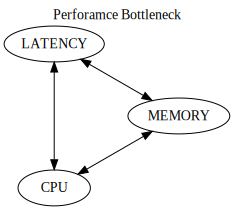

In [2]:
bottlenecks

In [3]:
# https://docs.python.org/3.7/library/profile.html
import cProfile
source_code_header = "########### Source Code: ###########"
source_code_tailer = "####################################\n"
from pygments import highlight
from pygments.lexers import Python3Lexer
from pygments.formatters import HtmlFormatter
from IPython.core.display import display, HTML
def display_source_code(filename):
    source_code = open(filename).read()
    text = f"{source_code_header}\n{source_code}\n{source_code_tailer}"
    display(HTML(highlight(text, Python3Lexer(), HtmlFormatter(full=True))))

In [4]:
display_source_code("src/example_abc.py")
!python -m cProfile src/example_abc.py 

         12 function calls in 0.304 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.304    0.304 example_abc.py:1(<module>)
        2    0.000    0.000    0.304    0.152 example_abc.py:12(d)
        1    0.000    0.000    0.304    0.304 example_abc.py:15(run)
        1    0.000    0.000    0.102    0.102 example_abc.py:3(a)
        1    0.000    0.000    0.202    0.202 example_abc.py:6(b)
        2    0.000    0.000    0.304    0.152 example_abc.py:9(c)
        1    0.000    0.000    0.304    0.304 {built-in method builtins.exec}
        2    0.304    0.152    0.304    0.152 {built-in method time.sleep}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




Metrics
- ncall
- tottime
- cumtime

In [5]:
%%bash
# pip install gprof2doc
python -m cProfile -o cprofile.pstats src/example_abc.py

# https://github.com/jrfonseca/gprof2dot
gprof2dot -f pstats cprofile.pstats | dot -Tpng -o img/visualize_cprofile.png

![visualize_cprofile](img/visualize_cprofile.png)

## What happens in asyncio world?
Asyncio was new in Python 3 and it's useful for concurrent data fetching for reducing latency.


In [6]:
code = display_source_code("src/asyncio_example_abc.py")
!python -m cProfile src/asyncio_example_abc.py

         28247 function calls (27763 primitive calls) in 0.242 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   134/93    0.000    0.000    0.011    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
      135    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
       56    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
       56    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:147(__enter__)
       56    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
      135    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
       56    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
       79    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:194(_lock_unlock_module)
     82/1    0.000    0.000    0.036    0.036 <frozen importlib._bootstrap>:211(_cal

In [7]:
%%bash
# pip install gprof2doc
python -m cProfile -o cprofile.pstats src/asyncio_example_abc.py

# https://github.com/jrfonseca/gprof2dot
gprof2dot -f pstats cprofile.pstats | dot -Tpng -o img/visualize_asyncio_cprofile.png

![visualize_cprofile](img/visualize_asyncio_cprofile.png)

# Limitations of cProfile
1. Unstable timer: the default timer varies by hardware spec (CPU model) and CPU utilization
2. No detailed callstack: only records one step caller-callee and cannot differentiate cost from different call stacks
3. Not support asyncio


# A Better Timer: CPU Instruction Counter

- CPU Instruction is much more stable.
- Use `perf_event_open` syscall http://man7.org/linux/man-pages/man2/perf_event_open.2.html

```
fd = syscall(__NR_perf_event_open, hw_event, pid, cpu, group_fd, flags);
read(fd, &read_format, sizeof(read_format))
```
- Use Cython binding for Python API

# Collect Call Stack
1. `perf` collects samples and decode the Python call stack
  - profile in separate process and doesn't interfere CPython process
  - harder to implement, CPU cycle
1. use Python profile hook to collect callstack and time
  - profile in CPython process and adds overhead to application
  - easier to implement, CPU instruction/cycle/latency

## Python profile hooks:

In [8]:
import sys
print(sys.setprofile.__doc__)
print("\n")
print(sys.settrace.__doc__)

setprofile(function)

Set the profiling function.  It will be called on each function call
and return.  See the profiler chapter in the library manual.


settrace(function)

Set the global debug tracing function.  It will be called on each
function call.  See the debugger chapter in the library manual.


https://docs.python.org/3/library/sys.html#sys.setprofile
![setprofile](img/setprofile.png)

## Python Frame object
- Object created for function call stack
https://docs.python.org/3/library/inspect.html
![visualize_cprofile](img/python_frame.png)


In [9]:
display_source_code("src/setprofile_callback.py")
!python "src/setprofile_callback.py"

run call
a call
c call
d call
d c_call
d c_return
d return
c return
a return
b call
c call
d call
d c_call
d c_return
d return
c return
b return
run return
<module> c_call


## Collect callstack and instruction count
![call_event_timeilne](img/call_event_timeilne.PNG)

In [10]:

# TODO: use function call timeline to explain how the time is updated
display_source_code("src/profiler.py")

After running the program with profiler, we get the call stack and time delta in a tree. We can traverse the tree to generate data and identify bottleneck.

In [11]:
display_source_code("src/collect_profiler_data.py")
!python "src/collect_profiler_data.py" "example_abc"

example_abc..run call
example_abc..a call
example_abc..c call
example_abc..d call
time.sleep c_call
time.sleep c_return
example_abc..d return
example_abc..c return
example_abc..a return
example_abc..b call
example_abc..c call
example_abc..d call
time.sleep c_call
time.sleep c_return
example_abc..d return
example_abc..c return
example_abc..b return
example_abc..run return
sys.setprofile c_call
['', 'example_abc..run', 'example_abc..a', 'example_abc..c', 'example_abc..d', 'time.sleep'] 0.10 0.10
['', 'example_abc..run', 'example_abc..a', 'example_abc..c', 'example_abc..d'] 0.10 0.00
['', 'example_abc..run', 'example_abc..a', 'example_abc..c'] 0.10 0.00
['', 'example_abc..run', 'example_abc..a'] 0.10 0.00
['', 'example_abc..run', 'example_abc..b', 'example_abc..c', 'example_abc..d', 'time.sleep'] 0.20 0.20
['', 'example_abc..run', 'example_abc..b', 'example_abc..c', 'example_abc..d'] 0.20 0.00
['', 'example_abc..run', 'example_abc..b', 'example_abc..c'] 0.20 0.00
['', 'example_abc..run', 

## Profile Asyncio
In Asyncio, async function (coroutine) is wrapped in a task object and run by event loop through steps.
So use f_back to find parent frame won't useful.
We could implement a async_task_factory to record the actually parent in task object when creating task.
```
def task_factory(loop, coro):
    task = asyncio.Task(coro, loop=loop)
    setattr(task, "ACTUAL_PARENT_FRAME", sys._getframe(1))
    return task
loop.set_task_factory(task_factory)
```
We'll also want to excludex some common system functions to simplify the callstack.

## Common CPU optimization strategies:
- Use faster implementation for common tasks
  - C implemntation binding through C API
    - ujson
  - use faster Python implementation
    - f-string
    - list/dict/set literal and comprehension

- Optimize bottleneck
  - Cython: compile Python code as C through C types
  - reduce nubmer of function call and statement


In [12]:
import timeit
def run_timeit(statement, setup):
    rlt = timeit.timeit(statement, setup=setup)
    return statement, f"{rlt:.2f}"


import dis
def benchmark(cases, setup=""):
    rlts = sorted([
        run_timeit(case, setup) for case in cases
    ], key=lambda x: x[1])
    for rlt in rlts:
        print(rlt)
    print()
    for case, _ in rlts:
        print(case)
        dis.dis(case)
        print()

In [13]:
import json, ujson
cases = ["json.loads(json_str)", "ujson.loads(json_str)"]
benchmark(cases, 
          setup='import json, ujson;\
          json_str = """{"name":"John",\
                         "age":30,\
                         "cars": {\
                            "car1":"Ford",\
                            "car2":"BMW",\
                            "car3":"Fiat"\
                         }\
                         }"""')

('ujson.loads(json_str)', '1.06')
('json.loads(json_str)', '3.37')

ujson.loads(json_str)
  1           0 LOAD_NAME                0 (ujson)
              2 LOAD_METHOD              1 (loads)
              4 LOAD_NAME                2 (json_str)
              6 CALL_METHOD              1
              8 RETURN_VALUE

json.loads(json_str)
  1           0 LOAD_NAME                0 (json)
              2 LOAD_METHOD              1 (loads)
              4 LOAD_NAME                2 (json_str)
              6 CALL_METHOD              1
              8 RETURN_VALUE



## String formating: f-string
- new in Python3.6
- f"text: {var:.2f}"

In [14]:
cases = [
    '"a + b = %d" % (a + b)',
    '"a + b = {}".format(a + b)',
    '"a + b = " + str(a + b)',
    'f"a + b = {a + b}"',
]
benchmark(cases, setup="a, b = 1, 2")

('f"a + b = {a + b}"', '0.16')
('"a + b = %d" % (a + b)', '0.17')
('"a + b = " + str(a + b)', '0.24')
('"a + b = {}".format(a + b)', '0.26')

f"a + b = {a + b}"
  1           0 LOAD_CONST               0 ('a + b = ')
              2 LOAD_NAME                0 (a)
              4 LOAD_NAME                1 (b)
              6 BINARY_ADD
              8 FORMAT_VALUE             0
             10 BUILD_STRING             2
             12 RETURN_VALUE

"a + b = %d" % (a + b)
  1           0 LOAD_CONST               0 ('a + b = %d')
              2 LOAD_NAME                0 (a)
              4 LOAD_NAME                1 (b)
              6 BINARY_ADD
              8 BINARY_MODULO
             10 RETURN_VALUE

"a + b = " + str(a + b)
  1           0 LOAD_CONST               0 ('a + b = ')
              2 LOAD_NAME                0 (str)
              4 LOAD_NAME                1 (a)
              6 LOAD_NAME                2 (b)
              8 BINARY_ADD
             10 CALL_FUNCTION     

## List/Dict/Set Literal and Comprehension
- List:
    - literal: []
    - comprehension: [i for i in range(n)]
- Dict:
    - literal: {key1: val1, key2: val2}
    - comprehension: {key: val for key, val in iterator}
- Set:
    - literal: {1, 2}
    - cmoprehension: {i for i in range(n)}

In [15]:
cases = ["list()", "[]"]
benchmark(cases)

('[]', '0.02')
('list()', '0.08')

[]
  1           0 BUILD_LIST               0
              2 RETURN_VALUE

list()
  1           0 LOAD_NAME                0 (list)
              2 CALL_FUNCTION            0
              4 RETURN_VALUE



In [16]:
cases = ["set([1,2,3,4,5])", "{1,2,3,4,5}"]
benchmark(cases)

('{1,2,3,4,5}', '0.14')
('set([1,2,3,4,5])', '0.27')

{1,2,3,4,5}
  1           0 LOAD_CONST               0 (1)
              2 LOAD_CONST               1 (2)
              4 LOAD_CONST               2 (3)
              6 LOAD_CONST               3 (4)
              8 LOAD_CONST               4 (5)
             10 BUILD_SET                5
             12 RETURN_VALUE

set([1,2,3,4,5])
  1           0 LOAD_NAME                0 (set)
              2 LOAD_CONST               0 (1)
              4 LOAD_CONST               1 (2)
              6 LOAD_CONST               2 (3)
              8 LOAD_CONST               3 (4)
             10 LOAD_CONST               4 (5)
             12 BUILD_LIST               5
             14 CALL_FUNCTION            1
             16 RETURN_VALUE



In [17]:
cases = ["dict(a=1, b=2, c=3)", '{"a": 1, "b": 2, "c": 3}']
benchmark(cases)

('{"a": 1, "b": 2, "c": 3}', '0.09')
('dict(a=1, b=2, c=3)', '0.24')

{"a": 1, "b": 2, "c": 3}
  1           0 LOAD_CONST               0 (1)
              2 LOAD_CONST               1 (2)
              4 LOAD_CONST               2 (3)
              6 LOAD_CONST               3 (('a', 'b', 'c'))
              8 BUILD_CONST_KEY_MAP      3
             10 RETURN_VALUE

dict(a=1, b=2, c=3)
  1           0 LOAD_NAME                0 (dict)
              2 LOAD_CONST               0 (1)
              4 LOAD_CONST               1 (2)
              6 LOAD_CONST               2 (3)
              8 LOAD_CONST               3 (('a', 'b', 'c'))
             10 CALL_FUNCTION_KW         3
             12 RETURN_VALUE



Use fewer statements for the same job
https://github.com/python/cpython/pull/3347/files
![](img/asyncio_attribute_access_optimization.png)

Reorder hot path https://github.com/python/cpython/pull/6836/files
![](img/asyncio_reorder_optimization.png)

## More information to collect
- call_count for average tottime
- timestamp for latency analysis
- inspect arguments and returns for lru_cache

## Latency Profiler
- collect timestams (start_time, end_time) instead of time_delata
![latency_profiling](img/latency_profiling_event_timeline.PNG)
- a lot of data (timestamps) are collected, need a good UI to visualize and interact with it
  - D3.js for interactive visualization.
    - Collapsible Indented Tree https://bl.ocks.org/mbostock/1093025

# Related works

### CPU regression monitoring and detection
#### Web Service Efficiency at Instagram with Python
##### https://instagram-engineering.com/web-service-efficiency-at-instagram-with-python-4976d078e366
- collect per API request CPU instruction in Django middleware
- build metric data pipeline 
- detect CPU regression caused by rollout

### Optimize CPython
#### Upgrade from Python 2.7 to Python 3.5
##### https://speakerdeck.com/pycon2017/keynote-lisa-guo-and-hui-ding-python-at-instagram
- Saved 12% CPU Instruction
![upgrade_python](img/upgrade_cpython.png)

#### Profiling CPython at Instagram
##### https://instagram-engineering.com/profiling-cpython-at-instagram-89d4cbeeb898
![visualize_cprofile](img/cpython_profiling_bytecode_frequency.jpeg)

### Memory optimization
#### Copy-on-write friendly Python garbage collection
https://instagram-engineering.com/copy-on-write-friendly-python-garbage-collection-ad6ed5233ddf
#### Adaptive process and memory management for Python web servers
https://instagram-engineering.com/adaptive-process-and-memory-management-for-python-web-servers-15b0c410a043

# Job Opportunities

- Facebook Singapore
  - Software Engineer
    - Intern
    - University Graduate
    - Full Time
      - Front End
      - General
      
- Instagram
  - New York: iOS/Android/Machine Learning
  - San Francisco: Android

- Facebook Menlo Park, Seattle, Redmond, Washinton DC, London, ...

https://www.facebook.com/careers

Question: jimmylai@instagram.com